In [10]:
"""         F L I G H T   T I C K E T   P R I C E
                   ... vytvoril Lukas Patrnciak
                   AIS ID: 92320
                   mail: xpatrnciak@stuba.sk
"""

'         F L I G H T   T I C K E T   P R I C E\n                   ... vytvoril Lukas Patrnciak\n                   AIS ID: 92320\n                   mail: xpatrnciak@stuba.sk\n'

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import category_encoders as ce
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
def outliers(data):
    cleaned_data = data.copy()
    
    for col in cleaned_data.select_dtypes(include=[np.number]).columns:
        Q1 = cleaned_data[col].quantile(0.25)
        Q3 = cleaned_data[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        cleaned_data = cleaned_data[(cleaned_data[col] >= lower_bound) & (cleaned_data[col] <= upper_bound)]
    
    return cleaned_data

def median_replace(data, column):
    data[column] = pd.to_numeric(data[column], errors='coerce')
    median_value = data[column].median()
    data[column] = data[column].fillna(median_value)

    return data

def generate_correlation_matrix(data, title_text):
    matrix = data.corr(numeric_only=True)

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
    plt.title(title_text)
    
    plt.show()

    return matrix
    
def train_model(split_ratio, x, y, iter_count, rand_state):
    values = []

    Xtrain, Xtest, Ytrain, Ytest = train_test_split(x, y, test_size=split_ratio, random_state=rand_state)
    
    scaler = StandardScaler()

    Xtrain = scaler.fit_transform(Xtrain)
    Xtest = scaler.transform(Xtest)

    model = LogisticRegression(max_iter=iter_count)
    model.fit(Xtrain, Ytrain)

    Ypred = model.predict(Xtest)

    accuracy = accuracy_score(Ytest, Ypred)
    conf_matrix = confusion_matrix(Ytest, Ypred)
    
    values.append(model)
    values.append(accuracy)
    values.append(conf_matrix)
    values.append(Xtrain)
    values.append(Xtest)
    values.append(Ytrain)
    values.append(Ytest)
        
    return values

# Funkcia na vypočítanie metrik a zobrazenie reziduálnych grafov (MSE a R2)
def evaluate_model(model, x_train, y_train, x_test, y_test, model_name):
    # Predikcie
    if model_name == 'Neural Network':
        y_train_pred = model.predict(x_train).ravel()
        y_test_pred = model.predict(x_test).ravel()
    else:
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)

    # Výpočet metrik pre tréningovú množinu
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    
    # Výpočet metrik pre testovaciu množinu
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)

    # Reziduá
    residuals_train = y_train - y_train_pred
    residuals_test = y_test - y_test_pred

    # Výstup metrík
    print(f"{model_name}")
    print(f"Training: MSE: {mse_train:.2f}, RMSE: {rmse_train:.2f}, R2: {r2_train:.2f}")
    print(f"Test: MSE: {mse_test:.2f}, RMSE: {rmse_test:.2f}, R2: {r2_test:.2f}")

    # Vizualizácia reziduálnych grafov
    fig, ax = plt.subplots(1, 2, figsize=(14, 6)) # ax - manipulácia s podgrafmi
    fig.suptitle("Residuals Analysis", fontsize=16)  # Globálny nadpis

    ax[0].scatter(y_train_pred, residuals_train, color="blue", alpha=0.5)
    ax[0].axhline(y=0, color="black", linestyle="--")
    ax[0].set_title(f"{model_name} - Training Residuals")
    ax[0].set_xlabel("Predicated Values")
    ax[0].set_ylabel("Residuals")

    ax[1].scatter(y_test_pred, residuals_test, color="red", alpha=0.5)
    ax[1].axhline(y=0, color="black", linestyle="--")
    ax[1].set_title(f"{model_name} - Test Residuals")
    ax[1].set_xlabel("Predicated Values")
    ax[1].set_ylabel("Residuals")

    plt.show()

def decision_tree_model(x_train, x_test, y_train, y_test, depth, rand_state):
    model = DecisionTreeRegressor(max_depth=depth, random_state=rand_state)
    model.fit(x_train, y_train)
    evaluate_model(model, x_train, y_train, x_test, y_test, 'Decision Tree')

    return model

def random_forest_model(x_train, x_test, y_train, y_test, n_est, rand_state):
    model = RandomForestRegressor(n_estimators=n_est, random_state=rand_state)
    model.fit(x_train, y_train)
    evaluate_model(model, x_train, y_train, x_test, y_test, 'Random Forest')

    return model

def svm_model(x_train, x_test, y_train, y_test, krn, c, e):
    model = SVR(kernel=krn, C=c, epsilon=e)
    model.fit(x_train, y_train)
    evaluate_model(model, x_train, y_train, x_test, y_test, "SVM")

    return model

def create_network(x_train, first_layer_neurons, second_layer_neurons, thirth_layer_neurons, first_dropout, second_dropout, thirth_dropout, learning_rate):
    model = Sequential()
    model.add(Input(shape=(x_train.shape[1],)))

    model.add(Dropout(first_dropout))
    model.add(Dense(first_layer_neurons, activation='relu'))
    model.add(Dropout(second_dropout))
    model.add(Dense(second_layer_neurons, activation='relu'))
    model.add(Dropout(thirth_dropout))
    model.add(Dense(thirth_layer_neurons, activation='relu'))

    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    model.summary()

    return model

In [13]:
file_path = "dataset_flights.csv"
flight_data = pd.read_csv(file_path)
stats = flight_data.describe()
null_values = flight_data.isnull().sum().sum()
duplicates = flight_data.duplicated().sum()
samples = flight_data.shape[0]

print("Pocet chybajucich hodnot:", null_values, "\nPocet duplicit:", duplicates, "\nPocet vzoriek:", samples, "\n\n", flight_data.head(), "\n\n", stats)

Pocet chybajucich hodnot: 17828 
Pocet duplicit: 0 
Pocet vzoriek: 50000 

          ID    airline   flight source_city departure_time        stops  \
0   95430.0  Air_India  AI-9517   Bangalore        Evening  two_or_more   
1  123622.0    AirAsia   I5-588     Kolkata      Afternoon          one   
2  273244.0  Air_India   AI-768     Kolkata      Afternoon          one   
3  268852.0    Vistara   UK-776     Kolkata        Evening          one   
4  231038.0    Vistara   UK-958      Mumbai      Afternoon          one   

    arrival_time destination_city     class  duration  days_left    price  
0          Night           Mumbai   Economy      5.08       10.0  13264.0  
1     Late_Night            Delhi   Economy     11.83       27.0   3014.0  
2          Night          Chennai  Business      8.08       16.0  55983.0  
3  Early_Morning        Bangalore  Business     14.25       27.0  52287.0  
4          Night        Bangalore  Business     10.25       14.0  54608.0   

               

In [14]:
string_set = ['airline','flight', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']
numerical_set = ['ID', 'duration', 'days_left', 'price']

for i in numerical_set:
    flight_data = median_replace(flight_data, i)

# Odstránenie stĺpcov s identifikátormi
flight_data = flight_data.drop(columns=['ID', 'flight'], errors='ignore')

flight_data = flight_data.drop_duplicates()
flight_data = flight_data.dropna()
flight_data = outliers(flight_data)
flight_data_original = flight_data.copy()

null_values = flight_data.isnull().sum().sum()
duplicates = flight_data.duplicated().sum()
samples = flight_data.shape[0]
stats = flight_data.describe()

string_columns = flight_data.select_dtypes(exclude=['number']).columns.tolist()
numerical_columns = flight_data.select_dtypes(exclude=['object']).columns.tolist()

print("Pocet chybajucich hodnot:", null_values, "\nPocet duplicit:", duplicates, "\nPocet vzoriek:", samples, "\nStlpce, v ktorych sa nachadza string:", string_columns, "\nStlpce, v ktorych sa nachadzaju cisla: ", numerical_columns, "\n\n", flight_data.head(), "\n\n", stats)

Pocet chybajucich hodnot: 0 
Pocet duplicit: 0 
Pocet vzoriek: 39993 
Stlpce, v ktorych sa nachadza string: ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class'] 
Stlpce, v ktorych sa nachadzaju cisla:  ['duration', 'days_left', 'price'] 

      airline source_city departure_time        stops   arrival_time  \
0  Air_India   Bangalore        Evening  two_or_more          Night   
1    AirAsia     Kolkata      Afternoon          one     Late_Night   
2  Air_India     Kolkata      Afternoon          one          Night   
3    Vistara     Kolkata        Evening          one  Early_Morning   
4    Vistara      Mumbai      Afternoon          one          Night   

  destination_city     class  duration  days_left    price  
0           Mumbai   Economy      5.08       10.0  13264.0  
1            Delhi   Economy     11.83       27.0   3014.0  
2          Chennai  Business      8.08       16.0  55983.0  
3        Bangalore  Business     14.25     

In [15]:
# Target Encoder
target_encoder = ce.TargetEncoder(cols=['source_city', 'destination_city', 'airline'])
flight_data[['source_city', 'destination_city', 'airline']] = target_encoder.fit_transform(flight_data[['source_city', 'destination_city', 'airline']], flight_data['price'])

# Label Encoder
label_encoder = LabelEncoder()
flight_data['class'] = label_encoder.fit_transform(flight_data['class'])
flight_data['stops'] = label_encoder.fit_transform(flight_data['stops'])
flight_data['departure_time'] = label_encoder.fit_transform(flight_data['departure_time'])
flight_data['arrival_time'] = label_encoder.fit_transform(flight_data['arrival_time'])

print("Nasledovne stlpce v datasete boli uspesne zakodovane: ", string_columns, "\n\n", flight_data)

Nasledovne stlpce v datasete boli uspesne zakodovane:  ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class'] 

             airline   source_city  departure_time  stops  arrival_time  \
0      23440.600996  21398.502799               2      1             5   
1       4228.005109  21720.568592               0      0             3   
2      23440.600996  21720.568592               0      0             5   
3      29588.411503  21720.568592               2      0             1   
4      29588.411503  20494.224254               0      0             5   
...             ...           ...             ...    ...           ...   
49995  23440.600996  21720.568592               1      1             2   
49996   5855.820537  21398.502799               2      0             3   
49997  29588.411503  21398.502799               2      0             2   
49998   6162.057384  20494.224254               4      2             0   
49999  29588.411503  19805.61

In [16]:
X = flight_data.drop('price', axis=1)  # Predpokladáme, že target obsahuje cieľovú hodnotu
Y = flight_data['price']

trained_model = train_model(0.3, X, Y, 200, 42)

X_train = trained_model[3]
X_test = trained_model[4]
Y_train = trained_model[5]
Y_test = trained_model[6]

Decision Tree
Training: MSE: 296373.53, RMSE: 544.40, R2: 1.00
Test: MSE: 67844716.99, RMSE: 8236.79, R2: 0.87


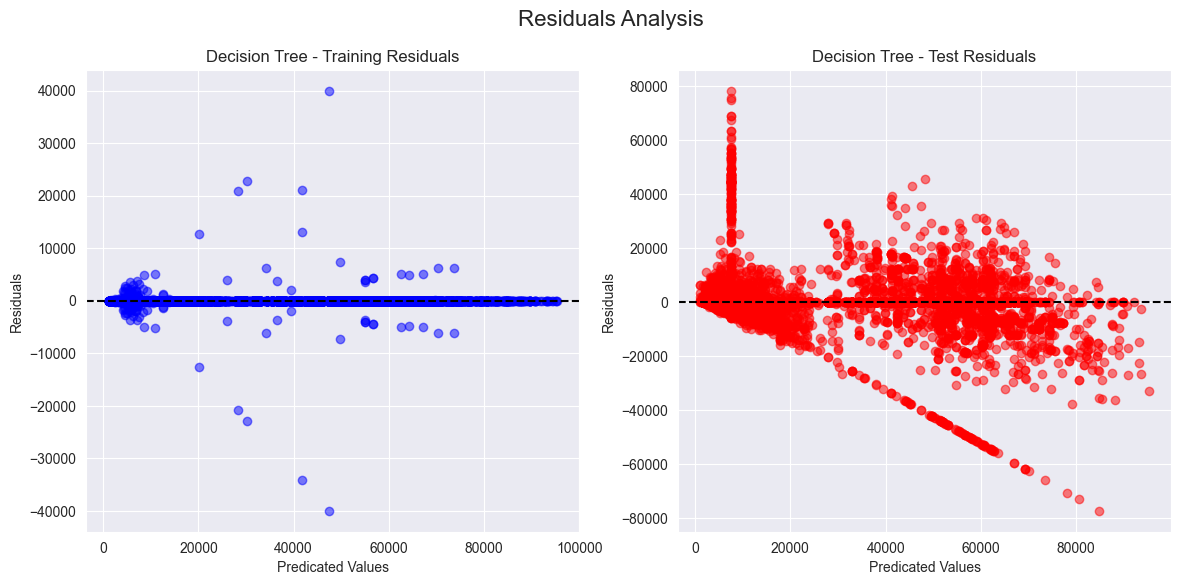

Random Forest
Training: MSE: 5268247.32, RMSE: 2295.27, R2: 0.99
Test: MSE: 38784499.18, RMSE: 6227.72, R2: 0.92


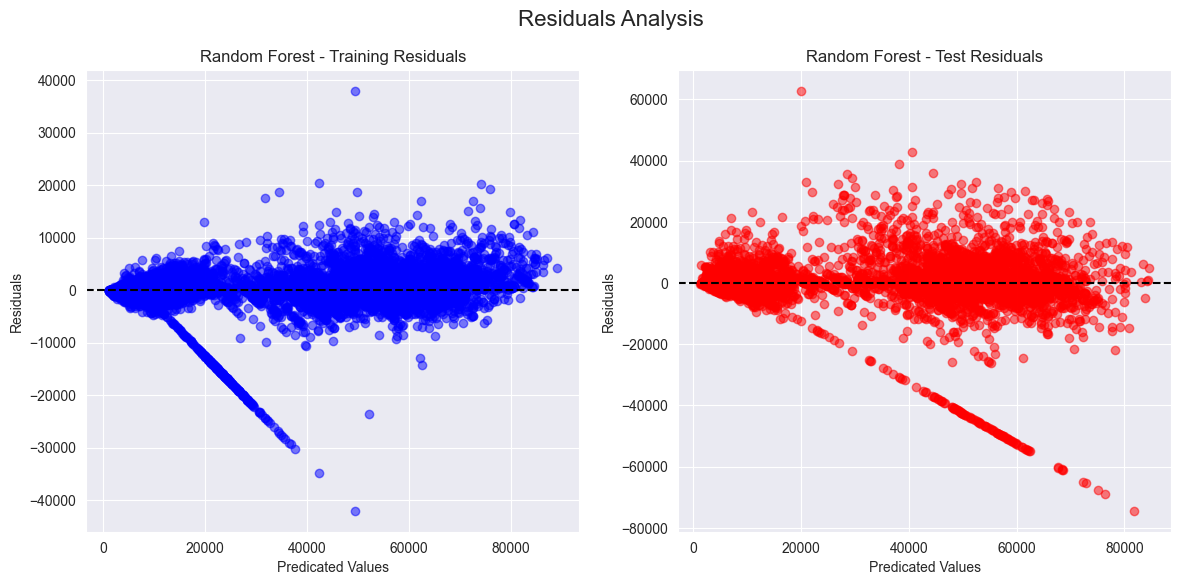

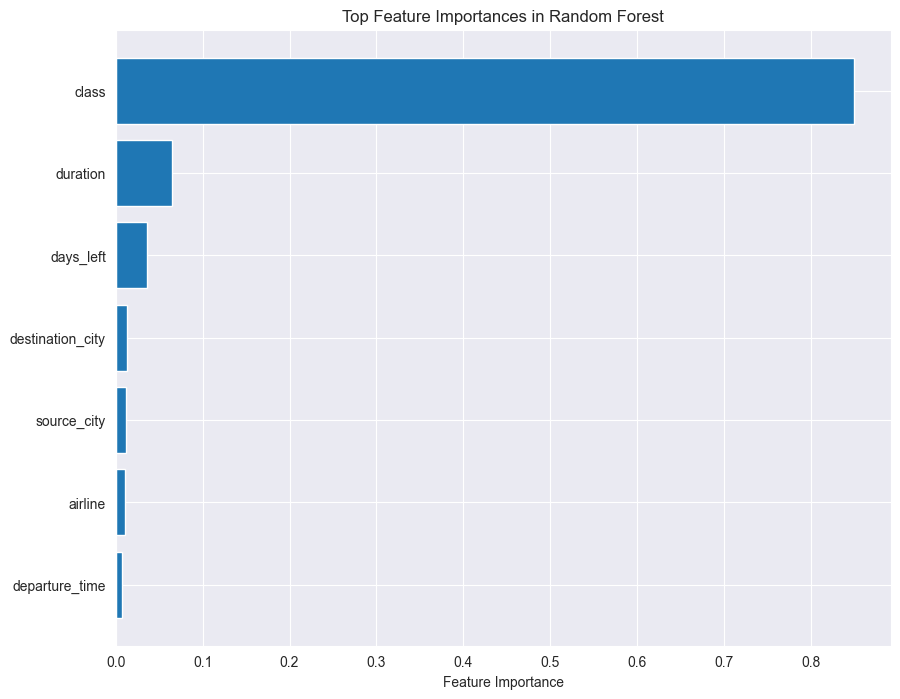

SVM
Training: MSE: 56687839.25, RMSE: 7529.13, R2: 0.89
Test: MSE: 59769189.34, RMSE: 7731.05, R2: 0.88


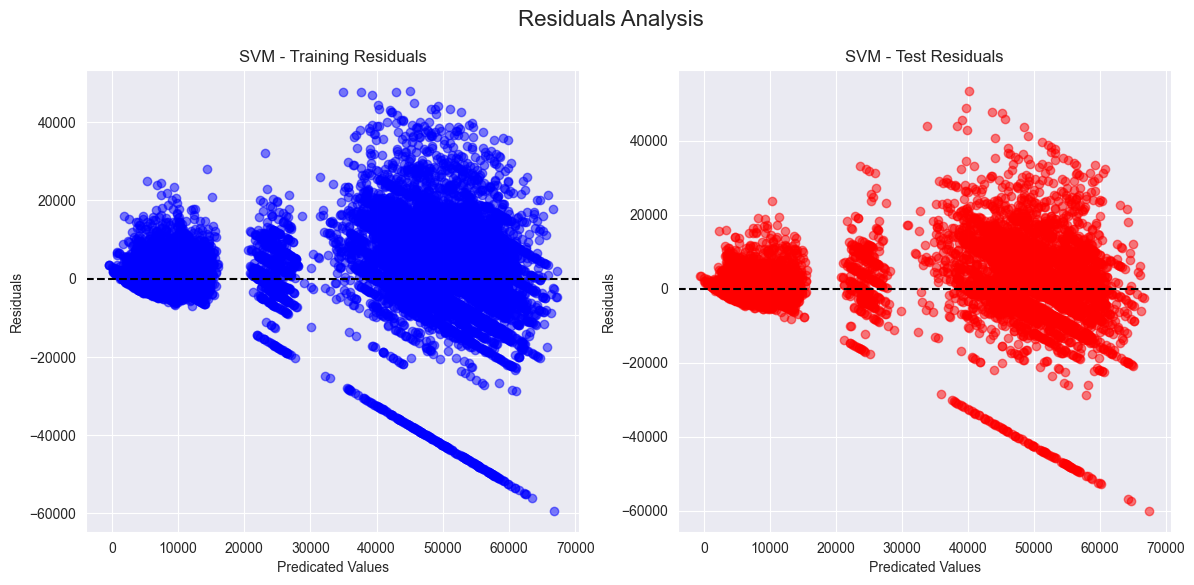

SVR(C=100)

In [17]:
# 1. Rozhodovací strom
dt_model = decision_tree_model(X_train, X_test, Y_train, Y_test, 100, 42)

# Vizualizácia stromu, ak je príliš veľký, obmedzte max_depth pri trénovaní modelu
#plt.figure(figsize=(20, 10))
#plot_tree(dt_model, filled=True, feature_names=X.columns)
#plt.title("Decision Tree")
#plt.show()

# 2. Ensemble model - Random Forest
rf_model = random_forest_model(X_train, X_test, Y_train, Y_test, 100, 42)

# Vizualizácia dôležitosti parametrov
feature_importances = rf_model.feature_importances_
selected_features_importance = feature_importances.argsort()[-7:]  # Vyberie 7 najdôležitejších vlastností

plt.figure(figsize=(10, 8))
plt.barh(X.columns[selected_features_importance], feature_importances[selected_features_importance])
plt.xlabel("Feature Importance")
plt.title("Top Feature Importances in Random Forest")
plt.show()

# 3. Model SVM
svm_model(X_train, X_test, Y_train, Y_test, 'rbf', 100, 0.1)

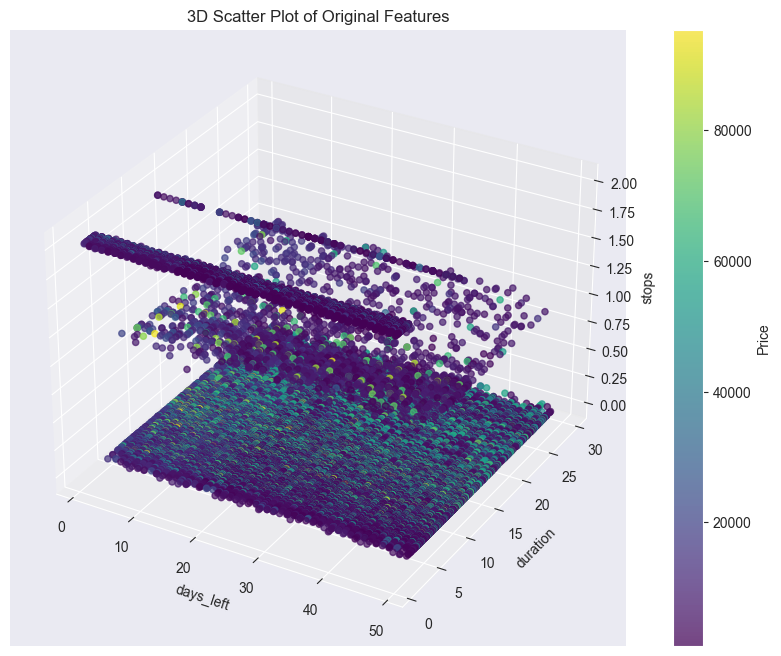

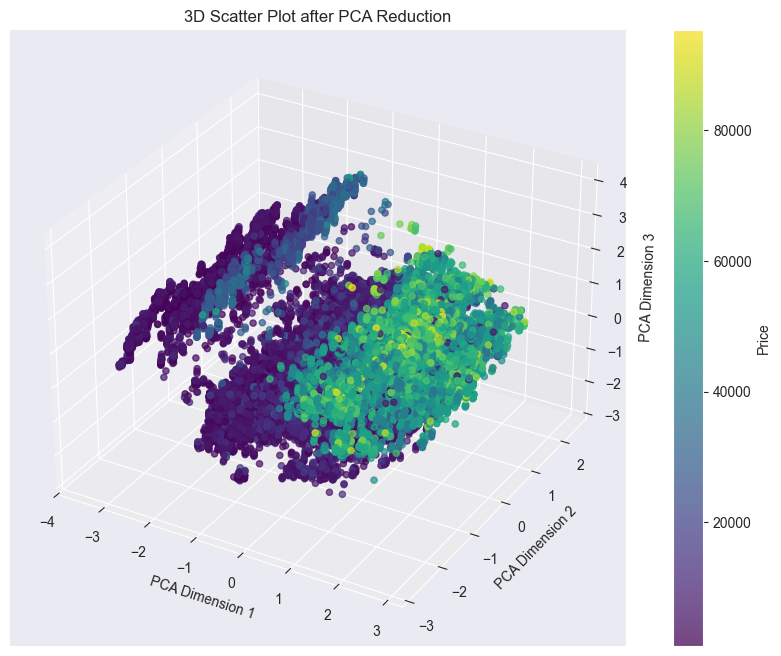

In [18]:
# Vybrané príznaky pre pôvodný scatter plot
feature_names = ["days_left", "duration", "stops"]

# 1. 3D scatter plot pre pôvodné dáta s vybranými príznakmi
fig_original_data = plt.figure(figsize=(12, 8))
ax_original_data = fig_original_data.add_subplot(111, projection='3d')

# Scatter plot s vybranými príznakmi a farebnou škálou podľa ceny
scatter = ax_original_data.scatter(
    flight_data[feature_names[0]], flight_data[feature_names[1]], flight_data[feature_names[2]],
    c=flight_data['price'], cmap='viridis', alpha=0.7
)

ax_original_data.set_xlabel(feature_names[0])
ax_original_data.set_ylabel(feature_names[1])
ax_original_data.set_zlabel(feature_names[2])
plt.colorbar(scatter, ax=ax_original_data, label='Price')
plt.title("3D Scatter Plot of Original Features")
plt.show()

# 2. Redukcia dimenzie po normalizácii pomocou PCA
X_pca = flight_data.drop('price', axis=1)
Y_pca = flight_data['price']

# Normalizácia dát
standardScaler = StandardScaler()
X_pca = standardScaler.fit_transform(X_pca)

# PCA na 3 dimenzie
pca_dim = PCA(n_components=3)
X_pca = pca_dim.fit_transform(X_pca)

# 3D scatter plot po redukcii dimenzie
fig_pca = plt.figure(figsize=(12, 8))
ax_pca = fig_pca.add_subplot(111, projection='3d')

scatter = ax_pca.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=Y_pca, cmap='viridis', alpha=0.7
)

ax_pca.set_xlabel("PCA Dimension 1")
ax_pca.set_ylabel("PCA Dimension 2")
ax_pca.set_zlabel("PCA Dimension 3")
plt.colorbar(scatter, ax=ax_pca, label='Price')
plt.title("3D Scatter Plot after PCA Reduction")
plt.show()

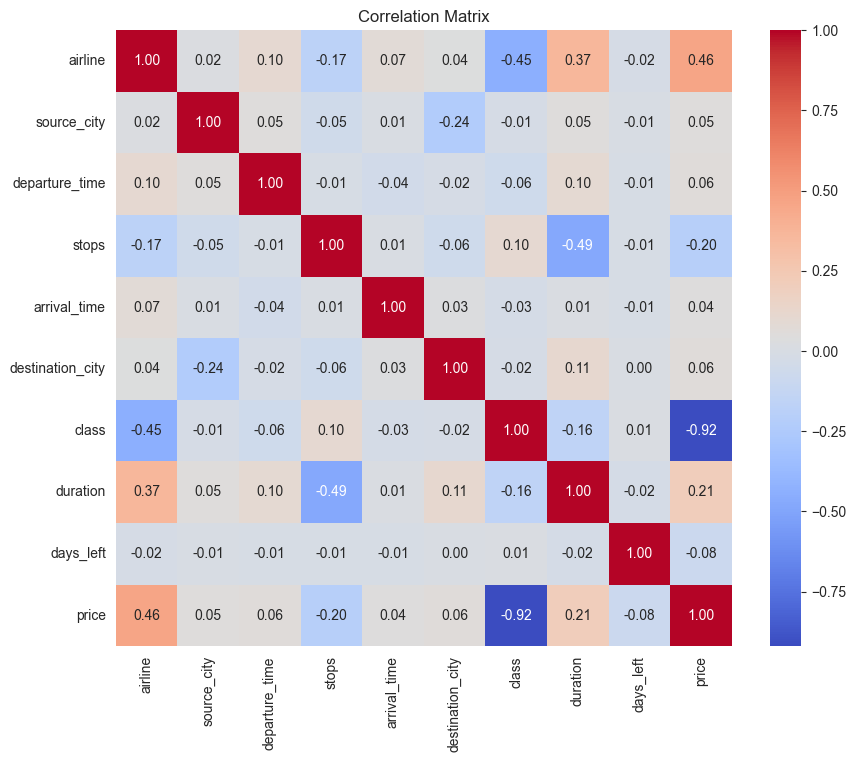


Filtered Features by Correlation:
 ['airline', 'stops', 'class', 'duration']

Random Forest
Training: MSE: 42203426.76, RMSE: 6496.42, R2: 0.92
Test: MSE: 51616104.62, RMSE: 7184.43, R2: 0.90


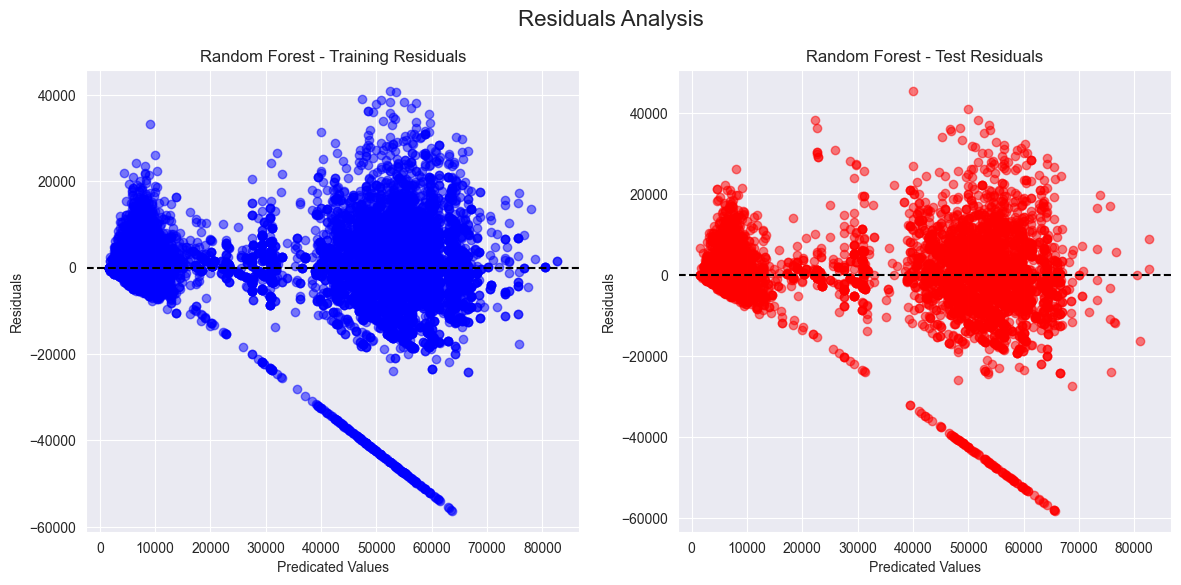


Selected Features by Importance:
 Index(['departure_time', 'airline', 'source_city', 'destination_city',
       'days_left', 'duration', 'class'],
      dtype='object')

Random Forest
Training: MSE: 5378566.56, RMSE: 2319.17, R2: 0.99
Test: MSE: 39868355.34, RMSE: 6314.14, R2: 0.92


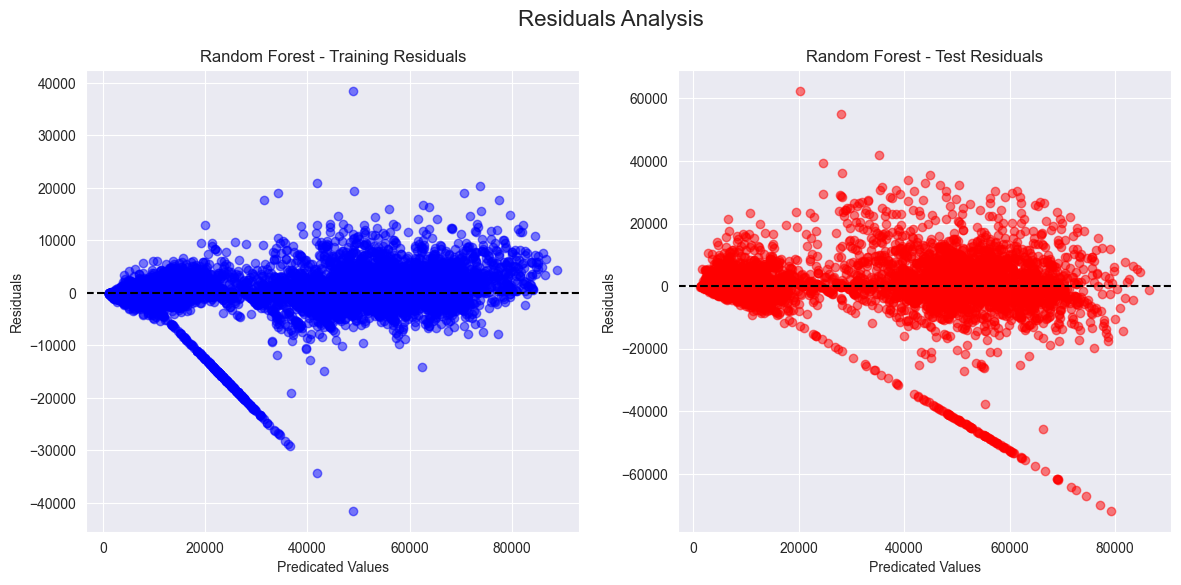

Random Forest
Training: MSE: 5624247.83, RMSE: 2371.55, R2: 0.99
Test: MSE: 41989086.53, RMSE: 6479.90, R2: 0.92


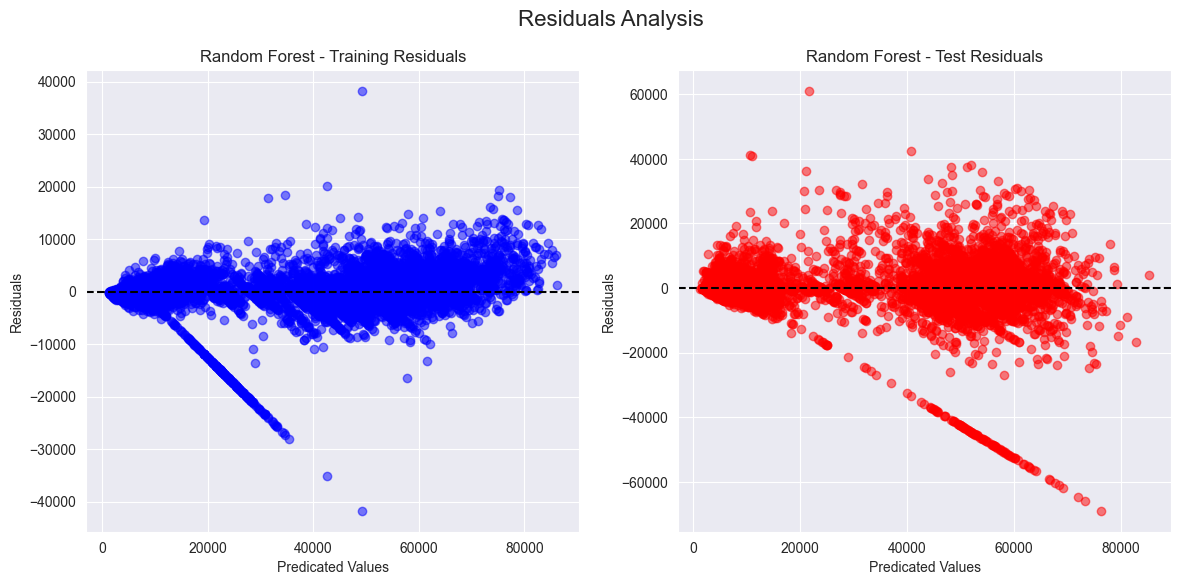

RandomForestRegressor(random_state=42)

In [19]:
# Najuspesnejsi model - rf_model
# 1. Vyber a trénovanie s korelačnými príznakmi
correlation_matrix = generate_correlation_matrix(flight_data, "Correlation Matrix")
features_correlation = correlation_matrix['price'].drop(labels='price')
selected_features_correlation = features_correlation[features_correlation.abs() > 0.1].index.tolist()

print("\nFiltered Features by Correlation:\n", selected_features_correlation)

flight_data_correlation = flight_data[selected_features_correlation]
X_train_correlation, X_test_correlation = train_test_split(flight_data_correlation, test_size=0.3, random_state=42)

print("")
random_forest_model(X_train_correlation, X_test_correlation, Y_train, Y_test, 100, 42)

# 2. Vyber a trénovanie s príznakmi podľa dôležitosti
print("\nSelected Features by Importance:\n", X.columns[selected_features_importance])

flight_data_importance = flight_data[X.columns[selected_features_importance]]
X_train_importance, X_test_importance = train_test_split(flight_data_importance, test_size=0.3, random_state=42)

print("")
random_forest_model(X_train_importance, X_test_importance, Y_train, Y_test, 100, 42)

# 3. Vyber podmnoziny a trénovanie s príznakmi podľa PCA
pca_var = PCA(n_components=0.95)  # Zachováme 95% vysvetlenej variancie
X_train_pca = pca_var.fit_transform(X_train) # Uz naskalovane z funcie train_model()
X_test_pca = pca_var.transform(X_test)

random_forest_model(X_train_pca, X_test_pca, Y_train, Y_test, 100, 42)

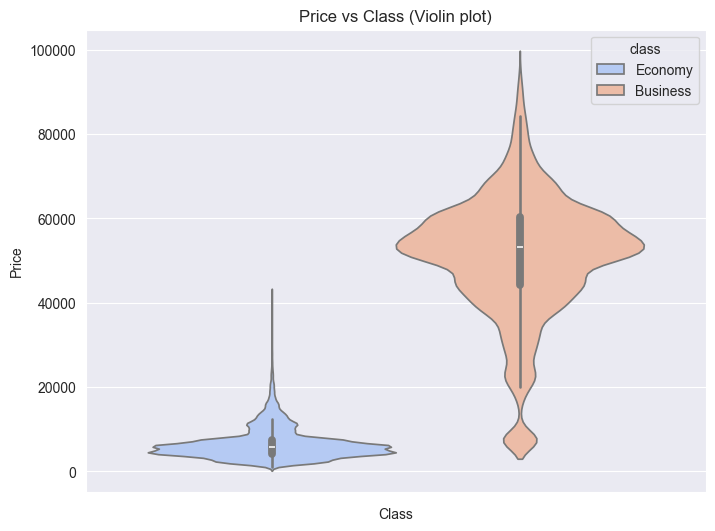

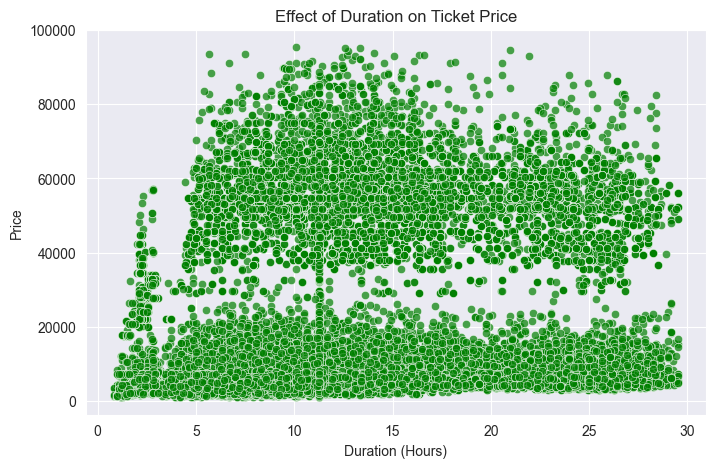

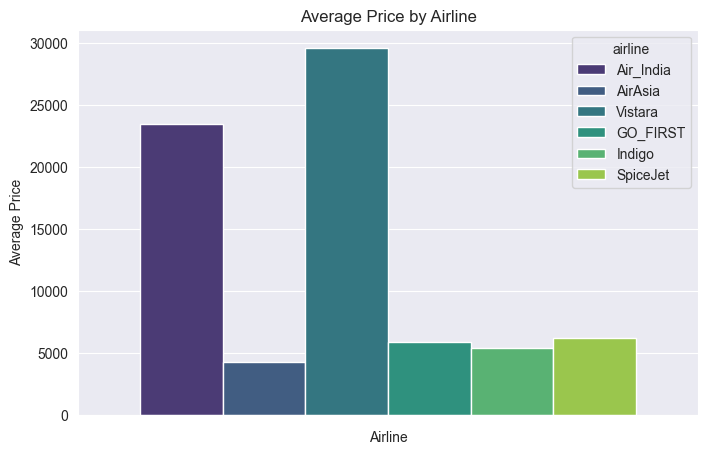

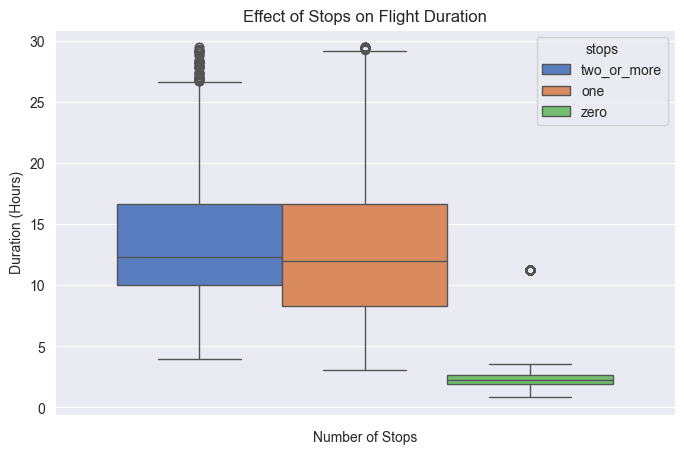

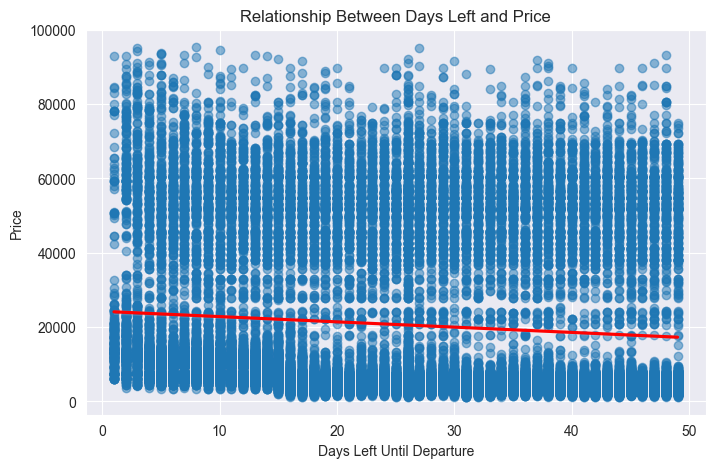

In [24]:
# EDA
# 1. Violin plot: Cena vs. Trieda
plt.figure(figsize=(8, 6))
sns.violinplot(data=flight_data_original, hue='class', y='price', palette="coolwarm")
plt.title('Price vs Class (Violin plot)')
plt.xlabel('Class')
plt.ylabel('Price')
plt.show()

# 2. Scatterplot: Duration vs. Price
plt.figure(figsize=(8, 5))
sns.scatterplot(data=flight_data_original, x='duration', y='price', alpha=0.7, color='green')
plt.title('Effect of Duration on Ticket Price')
plt.xlabel('Duration (Hours)')
plt.ylabel('Price')
plt.show()

# 3. Barplot: Airline vs. Average Price
plt.figure(figsize=(8, 5))
sns.barplot(data=flight_data_original, hue='airline', y='price', errorbar=None, palette="viridis")
plt.title('Average Price by Airline')
plt.xlabel('Airline')
plt.ylabel('Average Price')
plt.show()

# 4. Boxplot: Stops vs. Duration
plt.figure(figsize=(8, 5))
sns.boxplot(data=flight_data_original, hue='stops', y='duration', palette="muted")
plt.title('Effect of Stops on Flight Duration')
plt.xlabel('Number of Stops')
plt.ylabel('Duration (Hours)')
plt.show()

# 5. Scatterplot with Regression: Days Left vs. Price
plt.figure(figsize=(8, 5))
sns.regplot(data=flight_data_original, x='days_left', y='price', scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Relationship Between Days Left and Price')
plt.xlabel('Days Left Until Departure')
plt.ylabel('Price')
plt.show()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_3 (Dropout)             │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,913 (27.00 KB)

 Trainable params: 6,913 (27.00 KB)

 Non-trainable params: 0 (0.00 B)

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Neural Network
Training: MSE: 113411475.83, RMSE: 10649.48, R2: 0.77
Test: MSE: 115916342.48, RMSE: 10766.45, R2: 0.77


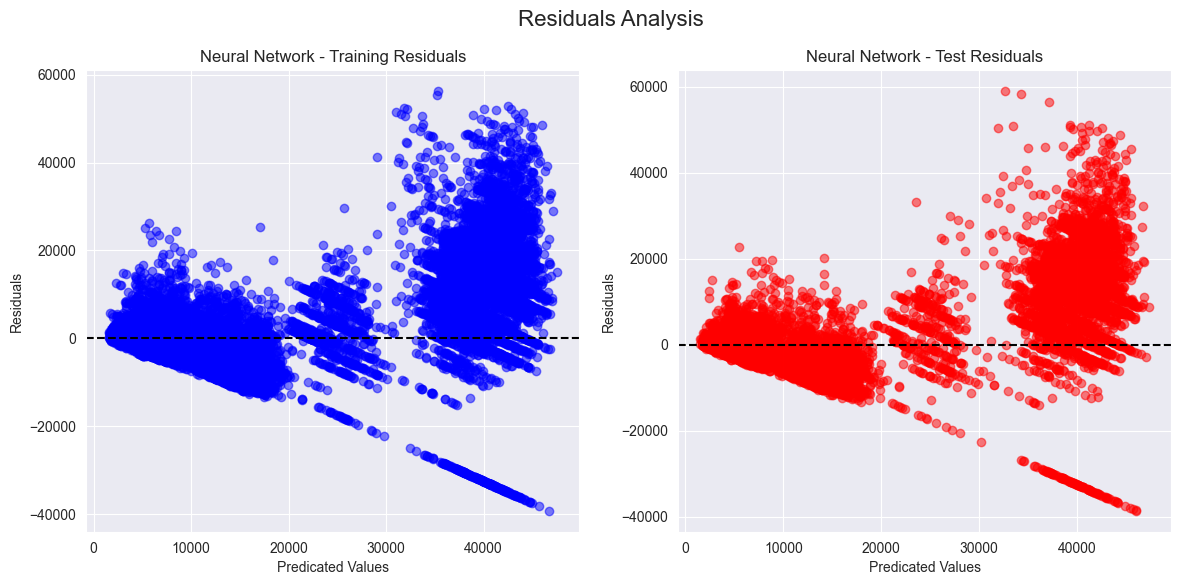

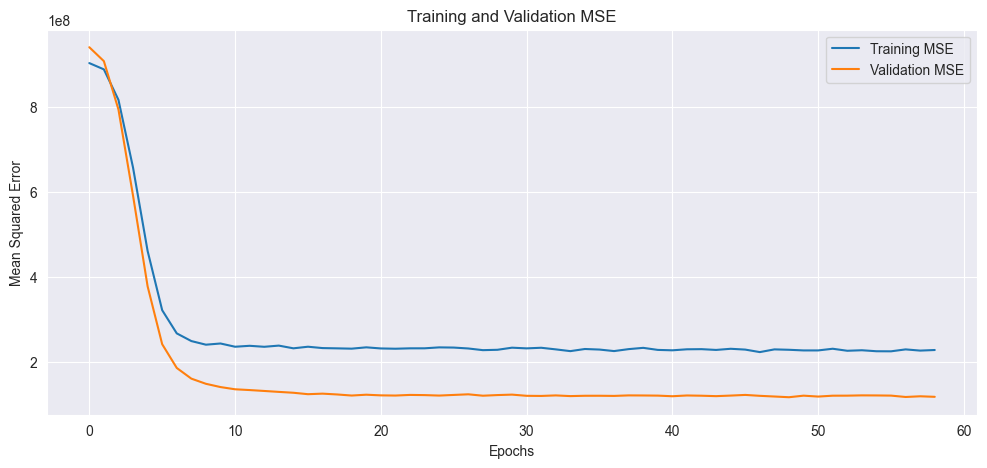

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

neural_network = create_network(X_train, 64, 64, 32, 0.4, 0.4, 0.3, 0.0001)
history = neural_network.fit(X_train, Y_train, validation_split=0.3, epochs=100, batch_size=32, verbose=0, callbacks=[early_stopping])
evaluate_model(neural_network, X_train, Y_train, X_test, Y_test, "Neural Network")

# Vykreslenie grafu
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation MSE')
plt.legend()
plt.show()